# 1. Notebook Styling and Library Installation
You can ignore this cell and move to library imports.

In [1]:
#!pip install graphviz
#!pip install pydotplus
#!conda install python-graphviz -y
#!pip install shap

In [2]:
import IPython
from IPython.display import display, HTML, SVG, Image
import graphviz
from graphviz import Source
from io import StringIO
import matplotlib.pyplot as plt
import pydotplus
import numpy as np
import pandas as pd
import sklearn
from sklearn import tree
from sklearn.metrics import * 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
import shap
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from category_encoders import *

from sklearn import svm
from sklearn.svm import SVC, LinearSVC

shap.initjs()


In [3]:
def displayConfusionMatrix(confusionMatrix, precisionNegative, precisionPositive, recallNegative, recallPositive, title):
    PLOT_FONT_SIZE = 14
    plt.rcParams['figure.figsize'] = [5, 5]
    confusionMatrix = np.transpose(confusionMatrix)
    plt.imshow(confusionMatrix, interpolation='nearest',cmap=plt.cm.Blues, vmin=0, vmax=100)
    xticks = np.array([-0.5, 0, 1,1.5])
    plt.gca().set_xticks(xticks)
    plt.gca().set_yticks(xticks)
    plt.gca().set_xticklabels(["", "Leave\nRecall=" + str(recallNegative) , "Stay\nRecall=" + str(recallPositive), ""], fontsize=PLOT_FONT_SIZE)
    plt.gca().set_yticklabels(["", "Leave\nPrecision=" + str(precisionNegative) , "Stay\nPrecision=" + str(precisionPositive), ""], fontsize=PLOT_FONT_SIZE)
    plt.ylabel("Predicted Class", fontsize=PLOT_FONT_SIZE)
    plt.xlabel("Actual Class", fontsize=PLOT_FONT_SIZE)
    plt.title(title, fontsize=PLOT_FONT_SIZE)
    for i in range(2):
        for j in range(2):
            text = plt.text(j, i, confusionMatrix[i][j], ha="center", va="center", color="white", size=15)            
    plt.show()

In [4]:
def calculateMetricsAndPrint(predictions, predictionsProbabilities, actualLabels):
    predictionsProbabilities = [item[1] for item in predictionsProbabilities]
    accuracy = round(accuracy_score(actualLabels, predictions) * 100, 2)
    precisionNegative = round(precision_score(actualLabels, predictions, average = None)[0] * 100, 2)
    precisionPositive = round(precision_score(actualLabels, predictions, average = None)[1] * 100, 2)
    recallNegative = round(recall_score(actualLabels, predictions, average = None)[0] * 100, 2)
    recallPositive = round(recall_score(actualLabels, predictions, average = None)[1] * 100, 2)
    auc = round(roc_auc_score(actualLabels, predictionsProbabilities) * 100, 2)
    confusionMatrix = confusion_matrix(actualLabels, predictions)
    print("Accuracy: %.2f\nPrecisionNegative: %.2f\nPrecisionPositive: %.2f\nRecallNegative: %.2f\nRecallPositive: %.2f\nAUC Score: %.2f\n" % 
          (accuracy, precisionNegative, precisionPositive, recallNegative, recallPositive, auc))
    displayConfusionMatrix(confusionMatrix, precisionNegative, precisionPositive, recallNegative, recallPositive, "Confusion Matrix")
    return auc

In [5]:
def showFeatureImportance(classifier, columns):
    columns = columns[1:]
    plt.rcParams['figure.figsize'] = [16, 6]
    PLOT_FONT_SIZE = 14
    featureImportance = classifier.feature_importances_
    featureImportanceWithColumns = list(reversed(sorted([[featureImportance[i], columns[i]] for i in range(0, len(columns))])))
    sortedColumns = [item[1] for item in featureImportanceWithColumns]
    sortedFeatures = [item[0] for item in featureImportanceWithColumns]
    xaxis = np.arange(len(featureImportance))
    plt.bar(xaxis, sortedFeatures, width = 0.5, color = 'white', hatch = '//', edgecolor = '#8a4191', linewidth = 2.0)
    plt.xticks(xaxis, sortedColumns, fontsize = PLOT_FONT_SIZE, rotation = 45)
    plt.yticks(fontsize = PLOT_FONT_SIZE)
    plt.xlabel("Feature Name",fontsize = PLOT_FONT_SIZE)
    plt.ylabel("Feature Importance",fontsize = PLOT_FONT_SIZE)
    plt.title("Feature Importances", fontsize = PLOT_FONT_SIZE)
    plt.show()
    importanceDataFrame = pd.DataFrame(featureImportanceWithColumns)
    display(importanceDataFrame)

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

# Load Data

In [598]:
#Read train data
data = pd.DataFrame(pd.read_csv("Data/HiltonPredictionData_Train.csv", ","))
data = data.dropna()
columns = list(data.columns)
# Read Test data
testDataForSubmission = pd.DataFrame(pd.read_csv("Data/HiltonPredictionData_Test.csv", ","))
testDataForSubmission = testDataForSubmission.dropna()
# data.head()


In [599]:
# col = list(data.columns.values)
first_col= data.pop("IntentToStay")
# print(data.head())
data.insert(0,'IntentToStay',first_col)
data.head()

,IntentToStay,AnonymousID,HotelInncode,HotelBrand,HotelChainScale,Generation,Department,FullTimePartTime,Tenure,ManagementLevel,WorkLifeBalance,LearningDevelopment,Communication,Voice,RewardsBenefits,WorkEnvironment
0,1,22684,100234,11,4,1,24,1,6,2,4.5,4.67,4.67,5.0,5.0,4.5
1,0,38792,100100,11,4,1,12,1,5,4,2.0,2.33,4.00,3.5,2.5,4.0
2,1,23552,100246,3,2,3,20,1,8,1,5.0,5.00,5.00,5.0,5.0,5.0
3,1,10801,100209,10,5,1,21,1,8,2,4.5,2.67,2.00,2.5,4.0,2.5
4,1,18343,100099,4,3,2,38,1,8,1,5.0,4.67,4.67,5.0,5.0,5.0


# Feature Engineering

In [600]:
def num_5point (row):
    counter=0
    if row['RewardsBenefits'] == 5 :
        counter = counter+ 1
    if row['WorkEnvironment'] == 5:
        counter = counter+ 1
    if row['WorkLifeBalance'] == 5 :
        counter = counter+ 1
    if row['Communication'] == 5 :
        counter = counter+ 1
    if row['Voice'] == 5 :
        counter = counter+ 1
    if row['LearningDevelopment'] == 5 :
        counter = counter+ 1
    if counter>=3:
        return 1
    return 0

def minCat (row):
    minPIV =  min(row['RewardsBenefits'],
    row['WorkEnvironment'],
    row['WorkLifeBalance'],
    row['Communication'],
    row['Voice'],
    row['LearningDevelopment'])
    if minPIV <=4:
        return 0
    else :
        return 1

def all5 (row):
    minPIV =  min(row['RewardsBenefits'],
    row['WorkEnvironment'],
    row['WorkLifeBalance'],
    row['Communication'],
    row['Voice'],
    row['LearningDevelopment'])
    if minPIV ==5:
        return 1
    else:
        return 0

def has_1point (row):
    if row['RewardsBenefits'] in [1,2] :
        return 1
    if row['WorkEnvironment']  in [1,2] :
        return 1
    if row['WorkLifeBalance']  in [1,2] :
        return 1
    if row['Communication'] in [1,2] :
        return 1
    if row['Voice']  in [1,2] :
        return 1
    if row['LearningDevelopment'] in [1,2]  :
        return 1
    return 0

def workEnv (row):
    # counter=0
    # if row['RewardsBenefits'] in [4,5] :
    #     counter = counter+ 1
    if row['WorkEnvironment']  in [4,5] :
        return 1
    return 0

def RewardsBenefits (row):
    # counter=0
    # if row['RewardsBenefits'] in [4,5] :
    #     counter = counter+ 1
    if row['RewardsBenefits']  in [4,5] :
        return 1
    return 0

def WorkLifeBalance (row):
    # counter=0
    # if row['RewardsBenefits'] in [4,5] :
    #     counter = counter+ 1
    if row['WorkLifeBalance']  in [4,5] :
        return 1
    return 0

data['all5'] = data.apply (lambda row: all5(row), axis=1)
testDataForSubmission['all5'] = testDataForSubmission.apply (lambda row: all5(row), axis=1)

data['num5'] = data.apply (lambda row: num_5point(row), axis=1)
testDataForSubmission['num5'] = testDataForSubmission.apply (lambda row: num_5point(row), axis=1)

data['mincat'] = data.apply (lambda row: minCat(row), axis=1)
testDataForSubmission['mincat'] = testDataForSubmission.apply (lambda row: minCat(row), axis=1)

data['has1'] = data.apply (lambda row: has_1point(row), axis=1)
testDataForSubmission['has1'] = testDataForSubmission.apply (lambda row: has_1point(row), axis=1)

data['workEnv'] = data.apply (lambda row: workEnv(row), axis=1)
testDataForSubmission['workEnv'] = testDataForSubmission.apply (lambda row: workEnv(row), axis=1)

data['money'] = data.apply (lambda row: RewardsBenefits(row), axis=1)
testDataForSubmission['money'] = testDataForSubmission.apply (lambda row: RewardsBenefits(row), axis=1)

data['wlb'] = data.apply (lambda row: WorkLifeBalance(row), axis=1)
testDataForSubmission['wlb'] = testDataForSubmission.apply (lambda row: WorkLifeBalance(row), axis=1)
###########
def wlb_mutate (row):
    # counter=0
    # if row['RewardsBenefits'] in [4,5] :
    #     counter = counter+ 1
    if row['WorkLifeBalance']  in [1,2,3,4] :
        return 0
    else:
        return 1
data['WorkLifeBalance'] = data.apply (lambda row: wlb_mutate(row), axis=1)
testDataForSubmission['WorkLifeBalance'] = testDataForSubmission.apply (lambda row: wlb_mutate(row), axis=1)

##
def ld_mutate (row):
    # counter=0
    # if row['RewardsBenefits'] in [4,5] :
    #     counter = counter+ 1
    if row['LearningDevelopment']  in [1,2,3,4] :
        return 0
    else:
        return 1
data['LearningDevelopment'] = data.apply (lambda row: ld_mutate(row), axis=1)
testDataForSubmission['LearningDevelopment'] = testDataForSubmission.apply (lambda row: ld_mutate(row), axis=1)

###
def comm_mutate (row):
    # counter=0
    # if row['RewardsBenefits'] in [4,5] :
    #     counter = counter+ 1
    if row['Communication']  in [1,2,3,4] :
        return 0
    else:
        return 1
data['Communication'] = data.apply (lambda row: comm_mutate(row), axis=1)
testDataForSubmission['Communication'] = testDataForSubmission.apply (lambda row: comm_mutate(row), axis=1)

###
def voice_mutate (row):
    # counter=0
    # if row['RewardsBenefits'] in [4,5] :
    #     counter = counter+ 1
    if row['Voice']  in [1,2,3,4] :
        return 0
    else:
        return 1
data['Voice'] = data.apply (lambda row: voice_mutate(row), axis=1)
testDataForSubmission['Voice'] = testDataForSubmission.apply (lambda row: voice_mutate(row), axis=1)

####
def rb_mutate (row):
    # counter=0
    # if row['RewardsBenefits'] in [4,5] :
    #     counter = counter+ 1
    if row['RewardsBenefits']  in [1,2,3,4] :
        return 0
    else:
        return 1
data['RewardsBenefits'] = data.apply (lambda row: rb_mutate(row), axis=1)
testDataForSubmission['RewardsBenefits'] = testDataForSubmission.apply (lambda row: rb_mutate(row), axis=1)

####
def we_mutate (row):
    # counter=0
    # if row['RewardsBenefits'] in [4,5] :
    #     counter = counter+ 1
    if row['WorkEnvironment']  in [1,2,3,4] :
        return 0
    else:
        return 1
data['WorkEnvironment'] = data.apply (lambda row: we_mutate(row), axis=1)
testDataForSubmission['WorkEnvironment'] = testDataForSubmission.apply (lambda row: we_mutate(row), axis=1)



In [601]:
inspectDept = data[['Department', 'IntentToStay']]
data['dep'] = 0
testDataForSubmission['dep'] = 0
y = inspectDept.groupby(['Department']).mean().sort_values('IntentToStay').reset_index()
for index, row in y.iterrows():
    # if row.IntentToStay <= .1:
    #     # print(index)
    #     data.loc[data.Department == row.Department, "dep"] = 1
    #     testDataForSubmission.loc[testDataForSubmission.Department == row.Department, "dep"] = 1
    # if row.IntentToStay <= .2:
    #     # print(index)
    #     data.loc[data.Department == row.Department, "dep"] = 1
    #     testDataForSubmission.loc[testDataForSubmission.Department == row.Department, "dep"] = 2
    if row.IntentToStay < .5:
        # print(index)
        data.loc[data.Department == row.Department, "dep"] = 0
        testDataForSubmission.loc[testDataForSubmission.Department == row.Department, "dep"] = 0
    # elif row.IntentToStay <= .4:
    #     # print(index)
    #     data.loc[data.Department == row.Department, "dep"] = 2
    #     testDataForSubmission.loc[testDataForSubmission.Department == row.Department, "dep"] = 4
    # elif row.IntentToStay <= .5:
    #     # print(index)
    #     data.loc[data.Department == row.Department, "dep"] = 5
    #     testDataForSubmission.loc[testDataForSubmission.Department == row.Department, "dep"] = 5
    else :
        # print(index)
        data.loc[data.Department == row.Department, "dep"] = 1
        testDataForSubmission.loc[testDataForSubmission.Department == row.Department, "dep"] = 1
    # elif row.IntentToStay <= .7:
    #     # print(index)
    #     data.loc[data.Department == row.Department, "dep"] = 7
    # #     testDataForSubmission.loc[testDataForSubmission.Department == row.Department, "dep"] = 7
    # else:
    #     # print(index)
    #     data.loc[data.Department == row.Department, "dep"] = 3
    #     testDataForSubmission.loc[testDataForSubmission.Department == row.Department, "dep"] = 8
    # # elif row.IntentToStay <= .9:
    # #     # print(index)
    #     data.loc[data.Department == row.Department, "dep"] = 9
    #     testDataForSubmission.loc[testDataForSubmission.Department == row.Department, "dep"] = 9
    # else:
    #     # print(index)
    #     data.loc[data.Department == row.Department, "dep"] = 10
    #     testDataForSubmission.loc[testDataForSubmission.Department == row.Department, "dep"] = 10

inspectDept = data[['ManagementLevel', 'IntentToStay']]
data['mgmt'] = 0
testDataForSubmission['mgmt'] = 0
y = inspectDept.groupby(['ManagementLevel']).mean().sort_values('IntentToStay').reset_index()
for index, row in y.iterrows():
    if row.IntentToStay <= .55:
        # print(index)
        data.loc[data.ManagementLevel == row.ManagementLevel, "mgmt"] = 0
        testDataForSubmission.loc[testDataForSubmission.ManagementLevel == row.ManagementLevel, "mgmt"] = 0
    else :
        # print(index)
        data.loc[data.ManagementLevel == row.ManagementLevel, "mgmt"] = 1
        testDataForSubmission.loc[testDataForSubmission.ManagementLevel == row.ManagementLevel, "mgmt"] = 1


inspectDept = data[['Tenure', 'IntentToStay']]
data['ten'] = 0
testDataForSubmission['ten'] = 0
y = inspectDept.groupby(['Tenure']).mean().sort_values('IntentToStay').reset_index()
for index, row in y.iterrows():
    # if row.IntentToStay <= .48:
    #     # print(index)
    #     data.loc[data.Tenure == row.Tenure, "ten"] = 1
    #     testDataForSubmission.loc[testDataForSubmission.Tenure == row.Tenure, "ten"] = 1
    # elif row.IntentToStay <= .53:
    #     # print(index)
    #     data.loc[data.Tenure == row.Tenure, "ten"] = 2
    #     testDataForSubmission.loc[testDataForSubmission.Tenure == row.Tenure, "ten"] = 2
    if row.IntentToStay <= .59:
        # print(index)
        data.loc[data.Tenure == row.Tenure, "ten"] = 0
        testDataForSubmission.loc[testDataForSubmission.Tenure == row.Tenure, "ten"] = 0
    else :
        # print(index)
        data.loc[data.Tenure == row.Tenure, "ten"] = 1
        testDataForSubmission.loc[testDataForSubmission.Tenure == row.Tenure, "ten"] = 1

inspectDept = data[['Generation', 'IntentToStay']]
data['gen'] = 0
testDataForSubmission['gen'] = 0
y = inspectDept.groupby(['Generation']).mean().sort_values('IntentToStay').reset_index()
for index, row in y.iterrows():
    if row.IntentToStay <= .54:
        # print(index)
        data.loc[data.Generation == row.Generation, "gen"] = 0
        testDataForSubmission.loc[testDataForSubmission.Generation == row.Generation, "gen"] = 0
    else :
        # print(index)
        data.loc[data.Generation == row.Generation, "gen"] = 1
        testDataForSubmission.loc[testDataForSubmission.Generation == row.Generation, "gen"] = 1

        
# inspectDept = data[['HotelBrand', 'IntentToStay']]
# data['brand'] = 0
# testDataForSubmission['brand'] = 0
# y = inspectDept.groupby(['HotelBrand']).mean().sort_values('IntentToStay').reset_index()
# for index, row in y.iterrows():
#     if row.IntentToStay <= .53:
#         # print(index)
#         data.loc[data.HotelBrand == row.HotelBrand, "brand"] = 1
#         testDataForSubmission.loc[testDataForSubmission.HotelBrand == row.HotelBrand, "brand"] = 1
#     elif row.IntentToStay <= .55:
#         # print(index)
#         data.loc[data.HotelBrand == row.HotelBrand, "brand"] = 2
#         testDataForSubmission.loc[testDataForSubmission.HotelBrand == row.HotelBrand, "brand"] = 2
#     else :
#         # print(index)
#         data.loc[data.HotelBrand == row.HotelBrand, "brand"] = 3
#         testDataForSubmission.loc[testDataForSubmission.HotelBrand == row.HotelBrand, "brand"] = 3

# inspectDept = data[['HotelChainScale', 'IntentToStay']]
# data['chain'] = 0
# testDataForSubmission['chain'] = 0
# y = inspectDept.groupby(['HotelChainScale']).mean().sort_values('IntentToStay').reset_index()
# for index, row in y.iterrows():
#     if row.IntentToStay <= .44:
#         # print(index)
#         data.loc[data.HotelChainScale == row.HotelChainScale, "chain"] = 1
#         testDataForSubmission.loc[testDataForSubmission.HotelChainScale == row.HotelChainScale, "chain"] = 1
#     elif row.IntentToStay <= .535:
#         # print(index)
#         data.loc[data.HotelChainScale == row.HotelChainScale, "chain"] = 2
#         testDataForSubmission.loc[testDataForSubmission.HotelChainScale == row.HotelChainScale, "chain"] = 2
#     else :
#         # print(index)
#         data.loc[data.HotelChainScale == row.HotelChainScale, "chain"] = 3
#         testDataForSubmission.loc[testDataForSubmission.HotelChainScale == row.HotelChainScale, "chain"] = 3



In [602]:
varToInspect = 'RewardsBenefits'
num=data.shape[0]
inspect = data[[varToInspect, 'IntentToStay']]
x=inspect.groupby(by=varToInspect).mean().sort_values('IntentToStay', ascending=True)
# x=inspect.groupby([varToInspect,'Department']).mean().sort_values('IntentToStay', ascending=True)

print(x)

print("\n\n% of data:")
print(inspect.groupby(by=[varToInspect]).count()/num)
# print(inspect.groupby([varToInspect,'Department']).count()/num)
# df.groupby(by=["B", "C"]).aggregate(pd.np.sum)
num

                 IntentToStay
RewardsBenefits              
0                    0.265583
1                    0.670578


% of data:
                 IntentToStay
RewardsBenefits              
0                      0.3075
1                      0.6925


4800

In [603]:

# first_col= data.pop("IntentToStay")
# # print(data.head())

# encodertrain=OneHotEncoder(cols=['WorkLifeBalance','LearningDevelopment','Communication','Voice','RewardsBenefits']).fit(data)

# data = encodertrain.transform(data)
# testDataForSubmission = encodertrain.transform(testDataForSubmission)
# data.insert(0,'IntentToStay',first_col)
data.head()


,IntentToStay,AnonymousID,HotelInncode,HotelBrand,HotelChainScale,Generation,Department,FullTimePartTime,Tenure,ManagementLevel,WorkLifeBalance,LearningDevelopment,Communication,Voice,RewardsBenefits,WorkEnvironment,all5,num5,mincat,has1,workEnv,money,wlb,dep,mgmt,ten,gen
0,1,22684,100234,11,4,1,24,1,6,2,1,1,1,1,1,1,0,0,1,0,0,1,0,1,0,0,0
1,0,38792,100100,11,4,1,12,1,5,4,0,1,0,1,1,0,0,0,0,1,1,0,0,1,0,0,0
2,1,23552,100246,3,2,3,20,1,8,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1
3,1,10801,100209,10,5,1,21,1,8,2,1,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0
4,1,18343,100099,4,3,2,38,1,8,1,1,1,1,1,1,1,0,1,1,0,1,1,1,0,1,1,1


In [604]:
columns = list(data.columns)
columnst = list(testDataForSubmission.columns)
len(columns)-1==len(columnst)

True

In [605]:
columns

['IntentToStay',
 'AnonymousID',
 'HotelInncode',
 'HotelBrand',
 'HotelChainScale',
 'Generation',
 'Department',
 'FullTimePartTime',
 'Tenure',
 'ManagementLevel',
 'WorkLifeBalance',
 'LearningDevelopment',
 'Communication',
 'Voice',
 'RewardsBenefits',
 'WorkEnvironment',
 'all5',
 'num5',
 'mincat',
 'has1',
 'workEnv',
 'money',
 'wlb',
 'dep',
 'mgmt',
 'ten',
 'gen']

In [606]:
keep = [  'Generation',
 'FullTimePartTime',
 'Tenure',
 'WorkLifeBalance',
 'LearningDevelopment',
 'Communication',
 'Voice',
 'RewardsBenefits',
 'WorkEnvironment',
 'num5',
 'num1',
 'has1',
 'badDep',
 'badTenure']

keep = [
 'Generation_1',
 'Generation_2',
 'Generation_3',
 'FullTimePartTime_1',
 'FullTimePartTime_2',
 'Tenure_1',
 'Tenure_2',
 'Tenure_3',
 'Tenure_6',
 'WorkLifeBalance',
 'LearningDevelopment',
 'Communication',
 'Voice',
 'RewardsBenefits',
 'WorkEnvironment',
 'num5_1',
 'num5_2',
 'has1_1',
 'workEnv_1',
 'money_1',
 'wlb_1',
 'dep_1',
 'dep_2',
 'dep_3',
 'dep_4',
 'mgmt_2',
 'mgmt_3',
 'mgmt_4',
 'ten_1',
 'ten_2',
 'ten_3',
 'brand_3',
 'chain_2',
 'mincat_1',
 'mincat_2',
 'mincat_3',
 'mincat_4',
 'mincat_5',
  'all5']

keep = [
 'Generation_1',
 'Generation_2',
 'Generation_3',
 'FullTimePartTime_1',
 'FullTimePartTime_2',
 'Tenure_1',
 'Tenure_2',
 'Tenure_3',
'WorkLifeBalance_1',
 'WorkLifeBalance_2',
 'WorkLifeBalance_3',
 'LearningDevelopment_1',
 'LearningDevelopment_2',
 'LearningDevelopment_3',
 'Communication_1',
 'Communication_2',
 'Communication_3',
 'Voice_1',
 'Voice_2',
 'Voice_3',
 'RewardsBenefits_1',
 'RewardsBenefits_2',
 'RewardsBenefits_3',
 'WorkEnvironment_1',
 'WorkEnvironment_2',
 'WorkEnvironment_3',
 'num5_1',
 'num5_2',
 'has1_1',
 'workEnv_1',
 'money_1',
 'wlb_1',
 'dep_1',
 'dep_2',
 'dep_3',
 'dep_4',
 'mgmt_2',
 'mgmt_3',
 'mgmt_4',
 'ten_1',
 'ten_2',
 'ten_3',
 'brand_3',
 'chain_2',
 'mincat_1',
 'mincat_2',
 'mincat_3',
 'mincat_4',
 'mincat_5',
  'all5']

keep = [
 'WorkLifeBalance',
 'LearningDevelopment',
 'Communication',
 'Voice',
 'RewardsBenefits',
 'WorkEnvironment',
 'all5',
 'num5',
 'mincat',
 'has1',
 'workEnv',
 'money',
 'wlb',
 'dep',
 'mgmt',
 'ten',
 'gen']

columns = list(data.columns)
# The indicies we are using from the original data DF
indicies = []
for x in keep:
    indicies.append(columns.index(x))
print(indicies)

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]


In [607]:
data.columns

Index(['IntentToStay', 'AnonymousID', 'HotelInncode', 'HotelBrand',
       'HotelChainScale', 'Generation', 'Department', 'FullTimePartTime',
       'Tenure', 'ManagementLevel', 'WorkLifeBalance', 'LearningDevelopment',
       'Communication', 'Voice', 'RewardsBenefits', 'WorkEnvironment', 'all5',
       'num5', 'mincat', 'has1', 'workEnv', 'money', 'wlb', 'dep', 'mgmt',
       'ten', 'gen'],
      dtype='object')

In [608]:
for var in keep:
    num=data.shape[0]
    inspect = data[[var, 'IntentToStay']]
    x=inspect.groupby(by=var).mean().sort_values('IntentToStay', ascending=True)
    print(x)
    print('% data')
    print(inspect.groupby(by=[var]).count()/num)
    print('------------')


                 IntentToStay
WorkLifeBalance              
0                    0.233496
1                    0.707649
% data
                 IntentToStay
WorkLifeBalance              
0                    0.340833
1                    0.659167
------------
                     IntentToStay
LearningDevelopment              
0                        0.280891
1                        0.664357
% data
                     IntentToStay
LearningDevelopment              
0                        0.308542
1                        0.691458
------------
               IntentToStay
Communication              
0                  0.247769
1                  0.676039
% data
               IntentToStay
Communication              
0                  0.303542
1                  0.696458
------------
       IntentToStay
Voice              
0          0.259378
1          0.728357
% data
       IntentToStay
Voice              
0           0.38875
1           0.61125
------------
                 IntentT

In [609]:
## ## 4.2 Feature and Label Vectors  ##
columns = list(data.columns)
# Convert data to a list of lists
dataList = data.values.tolist()

# Get features
features = []

# Iterate over each row
for row in dataList:
    featureValues=[]
    # Replaced # Skip the first two columns because they are not needed and the last column because that's the label
    # Replaced # featureValues = row[10:]
    # This loop replaces the line above.   It loops through every row in dataList, adding ONLY the features we want to
    # keep.  These values from from the list `keep`, as well as the list indicies (indicies of features in keep list
    #  from data    DF.)
    for i in indicies:
        featureValues.append(row[i])
    
    # Replace NULL values with 0. Using an if-else statement within a list is called list comprehension
    featureValues = [float(value) if value != "#NULL!" else 0 for value in featureValues] 
    
    # Append the features to the feature list
    features.append(featureValues)
    
# Get labels from the data
labels = [row[0] for row in dataList]

# Label distribution for Leave and Stay respectively
print("Label distribution of 0 and 1", labels.count(0), labels.count(1))

Label distribution of 0 and 1 2179 2621


In [610]:
# Note - since the final test set is the blinded Kaggle data, this is essentially a validation set for parameter tuning
TEST_DATA_PERCENTAGE = 0.1# col = list(data.columns.values)
first_col= data.pop("IntentToStay")
# print(data.head())
data.insert(0,'IntentToStay',first_col)
data.head()

# Split into train and test
trainData, testData, trainLabels, testLabels = train_test_split(features, labels, test_size=TEST_DATA_PERCENTAGE)

In [611]:
# list(data.columns)
forCor = data.columns.isin(keep)
forCor[0] = True #Turn on Intent To Stay for correlation plot


In [612]:
# Re-initialize columns variable that is used everywhere..
columns = data.iloc[:,forCor].columns

In [613]:
columns

Index(['IntentToStay', 'WorkLifeBalance', 'LearningDevelopment',
       'Communication', 'Voice', 'RewardsBenefits', 'WorkEnvironment', 'all5',
       'num5', 'mincat', 'has1', 'workEnv', 'money', 'wlb', 'dep', 'mgmt',
       'ten', 'gen'],
      dtype='object')

In [614]:
# forCoor = data.copy()

# forCoor.insert(0,'IntentToStayy',data['IntentToStay'])
# correlations = data.iloc[:,forCor].corr()
# correlations.style.background_gradient(cmap='coolwarm').set_precision(2)

In [615]:
# 5. Machine Learning
## 5.1 Decision Trees

In [616]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Gradient Boosted Tree

In [617]:
# Create an instance of the decision tree algorithm. You can consider "classifier" as a function that is going to get training data and train a decision tree algorithm. Next, it will take any test data and make a prediction based on the learned decision tree
gbClassifier = gbClassifierWithGridSearch =GradientBoostingClassifier(ccp_alpha=0.0005, max_depth=5, max_features=0.7,
                           min_impurity_decrease=0, min_samples_leaf=8,
                           n_estimators=15)

gbClassifier =GradientBoostingClassifier(learning_rate=0.15, max_depth=6, max_features='sqrt',
                           min_samples_leaf=70, n_estimators=30)
# Train the decision tree model using the function .fit
gbClassifier.fit(trainData, trainLabels)

# Calculate training accuracy of the classifier
trainAccuracy = gbClassifier.score(trainData, trainLabels)

# Predict on test data"
predictions = gbClassifier.predict(testData) # This will give binary labels e.g 0/1
predictionProbabilities = gbClassifier.predict_proba(testData) # This will give prediction probabilities for both labels e.g [0.3, 0.7] meaning 0.3 probability for 0 and 0.7 for 1.

Accuracy: 80.21
PrecisionNegative: 72.50
PrecisionPositive: 87.92
RecallNegative: 85.71
RecallPositive: 76.17
AUC Score: 86.26



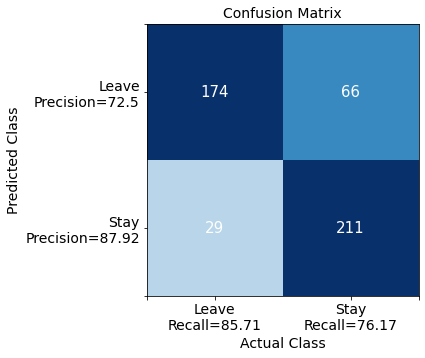

In [618]:
# Calculate metrics on test set and display them
gbtGridAUC = calculateMetricsAndPrint(predictions, predictionProbabilities, testLabels)

# Calculate FPR and TPR for use in ROC Curve Variance later on
falsePositiveRateGB, truePositiveRateGB, _ = roc_curve(testLabels, [item[1] for item in predictionProbabilities])

In [619]:
# columns

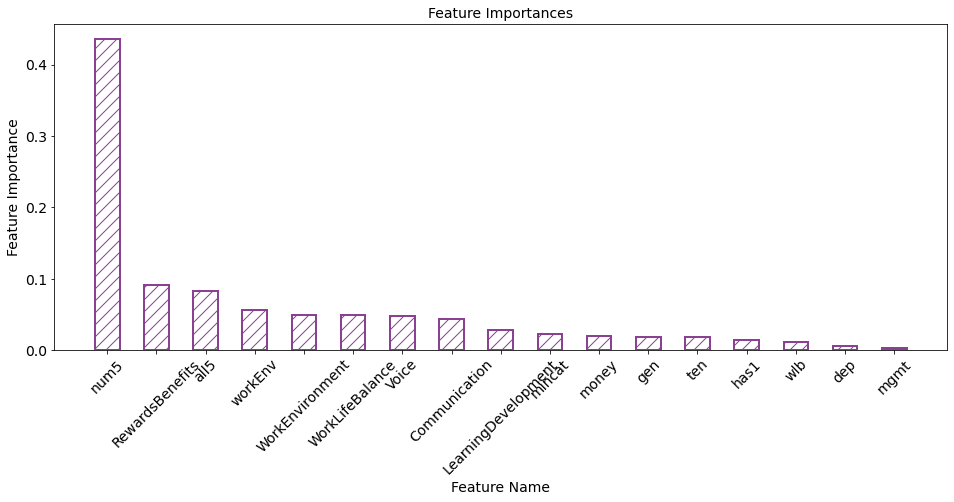

,0,1
0,0.435313,num5
1,0.091719,RewardsBenefits
2,0.083003,all5
3,0.056810,workEnv
4,0.049899,WorkEnvironment
5,0.049180,WorkLifeBalance
6,0.047795,Voice
7,0.044132,Communication
8,0.027612,LearningDevelopment
9,0.023131,mincat


In [620]:
# Calculate feature importance
showFeatureImportance(gbClassifier, columns)

## 5.3.1 Grid Search on XgBoost
XgBoost has so many parameters that you can tune. Let us try to do a grid search on those parameters to get the best model possible. The list of all parameters is listed here:

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [621]:
#####################################################################################################################################################
# Things you can change                                                                                                                             #
#####################################################################################################################################################
# GridSearchCV function takes in a parameter dictionary which is very important here. 
# The dictionary contains as keys the parameter names and values are the possible values of the parameter that you want to test
parameters = {'max_depth': [4, 5,6],
              'learning_rate': [0.1,0.2,.3,.35,.4,],
              'max_features':['sqrt',.9,.7],
             'n_estimators': [10,20,30,40],
             'min_samples_leaf': [50,100,160,200,250], 
             'subsample': [1.0]} # You can add different depths here.

# parameters = {'loss': ["deviance", "exponential"],
#             'max_depth': [3, 5,7,9],
#             'min_impurity_decrease': [0,.1,.05],
#             'learning_rate': [.005,0.1,0.15],
#             'n_estimators': [50,250,350],
#             'max_features':['None',.8,.6],
#             'subsample': [.6,.75,1.0]} 


# In order to learn about these parameters and their possible values, please go to:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier.feature_importances_
#####################################################################################################################################################

In [622]:

gbClassifier = GridSearchCV(GradientBoostingClassifier(),scoring='roc_auc', cv=5, param_grid=parameters, n_jobs=10, verbose=3)

# gbClassifierWithGridSearch=GradientBoostingClassifier(ccp_alpha=0.0005, max_depth=5, max_features=0.7,
#                            min_impurity_decrease=0, min_samples_leaf=8,
#                            n_estimators=15)


gbClassifier.fit(trainData, trainLabels)
trainAccuracy = gbClassifier.score(trainData, trainLabels)
predictions = gbClassifier.predict(testData)
predictionProbabilities = gbClassifier.predict_proba(testData)
falsePositiveRateGB, truePositiveRateGB, _ = roc_curve(testLabels, [item[1] for item in predictionProbabilities])


Fitting 5 folds for each of 900 candidates, totalling 4500 fits


In [623]:
gbClassifier.best_params_
gbClassifier.best_estimator_

GradientBoostingClassifier(learning_rate=0.2, max_depth=6, max_features='sqrt',
                           min_samples_leaf=250, n_estimators=40)

Accuracy: 80.62
PrecisionNegative: 73.11
PrecisionPositive: 88.02
RecallNegative: 85.71
RecallPositive: 76.90
AUC Score: 86.25



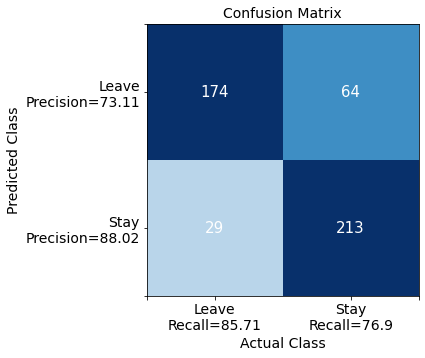

Best Parameters are:  {'learning_rate': 0.2, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 250, 'n_estimators': 40, 'subsample': 1.0}


In [624]:
# Calculate metrics on test set and display them
gbtGridAUC = calculateMetricsAndPrint(predictions, predictionProbabilities, testLabels)

# Calculate FPR and TPR for use in ROC Curve Variance later on

# Unfortunately, Feature importance does not work with GridSearch. Instead, we will find the best parameters.
print("Best Parameters are: ", gbClassifier.best_params_)

# RF

In [334]:
# rfClassifier=RandomForestClassifier(ccp_alpha=0.0005, max_depth=7, max_features=0.8,
#                        min_impurity_decrease=0, min_samples_leaf=9,
#                        n_estimators=15, random_state=201)

# rfClassifier.fit(trainData, trainLabels)
# predictions = rfClassifier.predict(testData)
# predictionProbabilities = rfClassifier.predict_proba(testData)

# # Calculate metrics on test set and display them
# rfAUC = calculateMetricsAndPrint(predictions, predictionProbabilities, testLabels)

# # Calculate FPR and TPR for use in ROC Curve Variance later on
# falsePositiveRateRF, truePositiveRateRF, _ = roc_curve(testLabels, [item[1] for item in predictionProbabilities])


In [335]:

parameters = {'max_depth': [4,5,6,7],
            'min_impurity_decrease': [0],
            'n_estimators': [5, 10,15],
            'max_features':['auto',.8,.7],
             'min_samples_leaf': [8,9,11],
            'ccp_alpha': [.0005,.001]} 

rf_tuned = GridSearchCV(RandomForestClassifier(random_state=201),param_grid=parameters, cv=4, n_jobs=6, verbose=1).fit(trainData, trainLabels)


Fitting 4 folds for each of 216 candidates, totalling 864 fits


In [336]:

rf_tuned.best_params_
rf_tuned.best_estimator_


RandomForestClassifier(ccp_alpha=0.0005, max_depth=7, min_impurity_decrease=0,
                       min_samples_leaf=11, n_estimators=15, random_state=201)

Accuracy: 81.46
PrecisionNegative: 77.27
PrecisionPositive: 85.00
RecallNegative: 81.34
RecallPositive: 81.55
AUC Score: 89.56



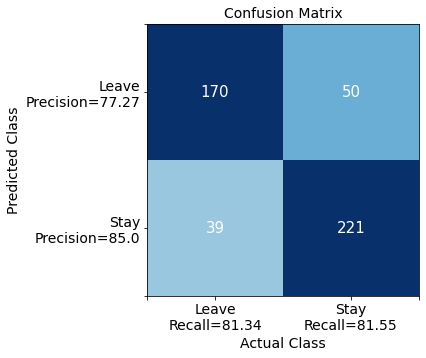

In [244]:
rfClassifier = RandomForestClassifier(ccp_alpha=0.0005, max_depth=7, max_features=0.8,
                       min_impurity_decrease=0, min_samples_leaf=11,
                       n_estimators=15, random_state=201)

rfClassifier.fit(trainData, trainLabels)
predictions = rfClassifier.predict(testData)
predictionProbabilities = rfClassifier.predict_proba(testData)

# Calculate metrics on test set and display them
rfAUC = calculateMetricsAndPrint(predictions, predictionProbabilities, testLabels)

# Calculate FPR and TPR for use in ROC Curve Variance later on
falsePositiveRateRF, truePositiveRateRF, _ = roc_curve(testLabels, [item[1] for item in predictionProbabilities])


In [245]:
columns

Index(['IntentToStay', 'Generation_1', 'Generation_2', 'Generation_3',
       'FullTimePartTime_1', 'FullTimePartTime_2', 'Tenure_1', 'Tenure_2',
       'Tenure_3', 'WorkLifeBalance_1', 'WorkLifeBalance_2',
       'WorkLifeBalance_3', 'LearningDevelopment_1', 'LearningDevelopment_2',
       'LearningDevelopment_3', 'Communication_1', 'Communication_2',
       'Communication_3', 'Voice_1', 'Voice_2', 'Voice_3', 'RewardsBenefits_1',
       'RewardsBenefits_2', 'RewardsBenefits_3', 'WorkEnvironment_1',
       'WorkEnvironment_2', 'WorkEnvironment_3', 'all5', 'num5_1', 'num5_2',
       'mincat_1', 'mincat_2', 'mincat_3', 'mincat_4', 'mincat_5', 'has1_1',
       'workEnv_1', 'money_1', 'wlb_1', 'dep_1', 'dep_2', 'dep_3', 'dep_4',
       'mgmt_2', 'mgmt_3', 'mgmt_4', 'ten_1', 'ten_2', 'ten_3', 'brand_3',
       'chain_2'],
      dtype='object')

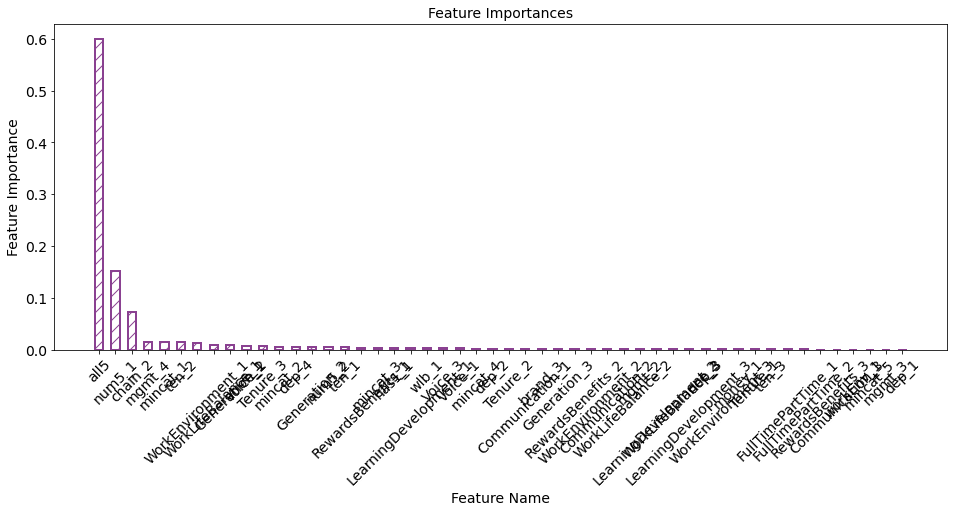

,0,1
0,0.599248,all5
1,0.151550,num5_1
2,0.072799,chain_2
3,0.015568,mgmt_4
4,0.015022,mincat_1
5,0.014677,ten_2
6,0.013425,WorkEnvironment_1
7,0.009270,WorkLifeBalance_1
8,0.009007,Generation_1
9,0.007058,Voice_2


In [246]:
showFeatureImportance(rfClassifier, columns)

# XGB

In [247]:
from xgboost import XGBClassifier
from pandas import DataFrame

In [248]:
xdf = DataFrame(trainData)
ydf = DataFrame(trainLabels, columns=['IntentToStay'])

xTestdf = DataFrame(testData)
yTestdf = DataFrame(testLabels, columns=['IntentToStay'])

In [249]:
xg = XGBClassifier(objective="binary:logistic")
param_grid = {'max_depth': [4,6,10],
'n_estimators': [10, 20],
'min_child_weight' :[1,.8],
'gamma': [0,.1,.8],
'subsample': [1,.8],
'lambda': [1,.8],
'alpha' : [0,.2]}
scorer = make_scorer(recall_score, pos_label="yes") # We are optimizing based on recall of 'yes' clas
tuned = GridSearchCV(xg, param_grid, cv=5, verbose=1, n_jobs=-1).fit(xdf, ydf)


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


In [250]:
tuned.best_params_
tuned.best_estimator_

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='', lambda=1,
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=20, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Accuracy: 81.67
PrecisionNegative: 78.40
PrecisionPositive: 84.27
RecallNegative: 79.90
RecallPositive: 83.03
AUC Score: 89.49



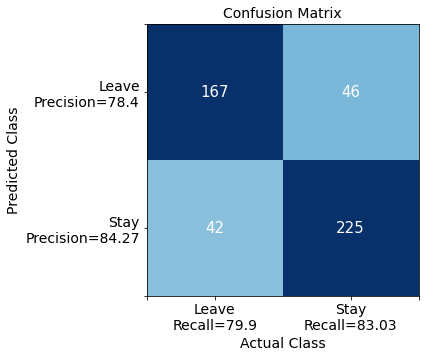

In [252]:

xg = XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=20, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
xg.fit(xdf, ydf)
predictions = xg.predict(xTestdf)
predictionProbabilities = xg.predict_proba(xTestdf)
# Calculate metrics on test set and display them
XGBCAUC = calculateMetricsAndPrint(predictions, predictionProbabilities, yTestdf)
# Calculate FPR and TPR for use in ROC Curve Variance later on
falsePositiveRateXG, truePositiveRateXG, _ = roc_curve(testLabels, [item[1] for item in predictionProbabilities])

# SVC

In [253]:

param_grid = {'C': np.logspace(.1, 10, 1),  
        'gamma': [.8,.7,.6,.5,.3, .2,0.1, 0.01,1 ], 
        'kernel': ['linear' ]}  

# grid = GridSearchCV(SVC(), param_grid, refit = True, verbose=5, n_jobs=10) 

# fitting the model for grid search 
# grid.fit(trainData, trainLabels)
# print(grid.best_params_) 
# print(grid.best_estimator_) 

##SVC(C=1.2589254117941673, gamma=0.8, kernel='linear')

              precision    recall  f1-score   support

           0       0.75      0.84      0.79       209
           1       0.86      0.79      0.82       271

    accuracy                           0.81       480
   macro avg       0.81      0.81      0.81       480
weighted avg       0.82      0.81      0.81       480

Accuracy: 81.04
PrecisionNegative: 75.43
PrecisionPositive: 86.29
RecallNegative: 83.73
RecallPositive: 78.97
AUC Score: 87.64



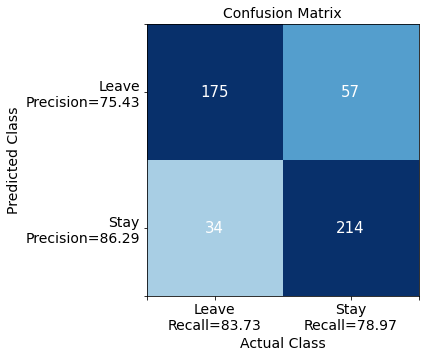

In [254]:
# mySVC = SVC(C=1, gamma=0.1, kernel='poly', degree=3, probability=True)
myLinearSVC = SVC(C=1.2589254117941673, gamma=0.1, kernel='linear', probability=True)
myLinearSVC.fit(trainData, trainLabels)

predictions = myLinearSVC.predict(testData)
print(classification_report(testLabels, predictions)) 
predictionProbabilities = myLinearSVC.predict_proba(testData)

# # Calculate metrics on test set and display them
linearSvcAUC = calculateMetricsAndPrint(predictions, predictionProbabilities, testLabels)

# # Calculate FPR and TPR for use in ROC Curve Variance later on
falsePositiveRateSVC, truePositiveRateSVC, _ = roc_curve(testLabels, [item[1] for item in predictionProbabilities])
# columns=list(dataGB.columns)


In [255]:
print("AUC values for different classifiers...")
print("Gradient Boosted Trees with Grid Search: %.3f\nRandom Forrest: %.3f\nSVC: %.3f\nXG: %.3f\n" % (gbtGridAUC,rfAUC,linearSvcAUC,XGBCAUC))

AUC values for different classifiers...
Gradient Boosted Trees with Grid Search: 89.890
Random Forrest: 89.560
SVC: 87.640
XG: 89.490



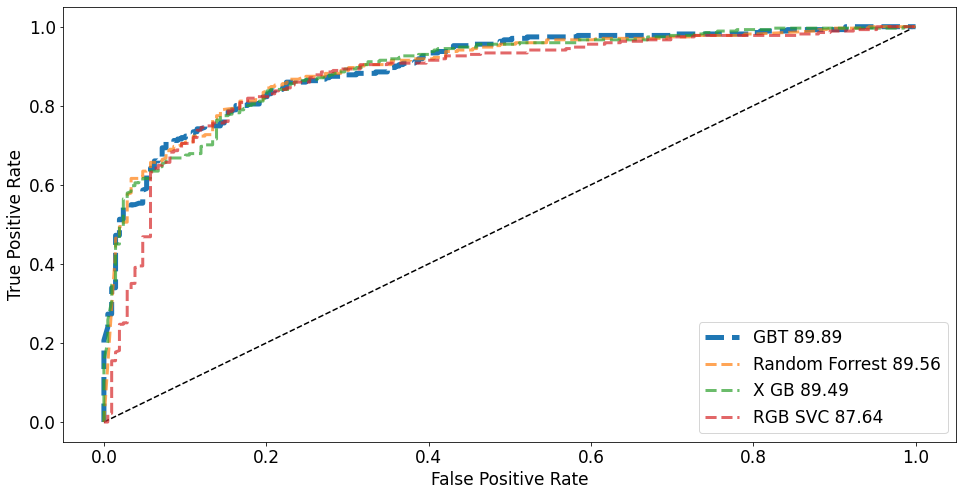

In [256]:
plt.rcParams['figure.figsize'] = [16, 8]
FONT_SIZE = 17

# plt.plot(falsePositiveRateDt, truePositiveRateDt, linewidth = 3, label = "DecisionTree(DT)")
# plt.plot(falsePositiveRateDtWithGridSearch, truePositiveRateDtWithGridSearch, linewidth = 3, label = "DTWithGridSearch")
# plt.plot(falsePositiveRateGb, truePositiveRateGb, linewidth = 3, label = "GradientBoostedTrees(GBT)")
plt.plot([0,1],[0,1], 'k--')
plt.plot(falsePositiveRateGB, truePositiveRateGB, linewidth = 5, label = "GBT " + str(gbtGridAUC), linestyle='--')
# plt.plot(falsePositiveRateLR, truePositiveRateLR, linewidth = 3, label = "Logistic Regression " + str(lrAUC), linestyle='--')
plt.plot(falsePositiveRateRF, truePositiveRateRF, linewidth = 3, label = "Random Forrest " + str(rfAUC), alpha=.7, linestyle='--')
plt.plot(falsePositiveRateXG, truePositiveRateXG, linewidth = 3, label = "X GB " + str(XGBCAUC), alpha=.7, linestyle='--')
plt.plot(falsePositiveRateSVC, truePositiveRateSVC, linewidth = 3, label = "RGB SVC " + str(linearSvcAUC), alpha=.7, linestyle='--')
# plt.plot(falsePositiveRateLinearSVC, truePositiveRateLinearSVC, linewidth = 3, label = "Linear SVC " + str(svcAUC), alpha=.7, linestyle='--')
plt.legend(fontsize=FONT_SIZE)
plt.xticks(fontsize=FONT_SIZE)
plt.yticks(fontsize=FONT_SIZE)
plt.xlabel("False Positive Rate", fontsize=FONT_SIZE)
plt.ylabel("True Positive Rate", fontsize=FONT_SIZE)
plt.show()

In [ ]:
columns

In [43]:
columns = list(testDataForSubmission.columns)
# The indicies we are using from the original data DF
indicies = []
for x in keep:
    print(x)
    indicies.append(columns.index(x))
print(indicies)



Generation_1
Generation_2
Generation_3
Department
FullTimePartTime_1
FullTimePartTime_2
Tenure_1
Tenure_2
Tenure_3
Tenure_4
Tenure_5
Tenure_6
Tenure_7
Tenure_8
WorkLifeBalance
LearningDevelopment
Communication
Voice
RewardsBenefits
WorkEnvironment
num5_1
num5_2
num5_3
has1_1
has1_2
workEnv_1
workEnv_2
money_1
money_2
wlb_1
wlb_2
dep_1
dep_2
dep_3
dep_4
mgmt_1
mgmt_2
mgmt_3
mgmt_4
ten_1
ten_2
ten_3
ten_4
brand_1
brand_2
brand_3
chain_1
chain_2
chain_3
[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]


In [44]:
# # Read data into a data frame
# testDataForSubmission = pd.DataFrame(pd.read_csv("Data/HiltonPredictionData_Test.csv", ","))

# # Delete null values
# testDataForSubmission = testDataForSubmission.dropna()

# Convert data to a list of lists
testDataListForSubmission = testDataForSubmission.values.tolist()

# Get features
testFeaturesForSubmission = []

# Iterate over each row
for row in testDataListForSubmission:
    
    # Skip the first two columns because they are not needed and the last column because that's the label
    featureValues = []
    for i in indicies:
        featureValues.append(row[i])
    # Replace NULL values with 0. Using an if-else statement within a list is called list comprehension
    featureValues = [float(value) if value != "#NULL!" else 0 for value in featureValues] 
    
    # Append the features to the feature list
    testFeaturesForSubmission.append(featureValues)

In [50]:
#GBC
resultsFile = open("Results/gbPredictionsGrid77.csv", "w")
resultsFile.write("Id,Expected\n")
for predictionProb, i in zip(gbClassifier.predict_proba(testFeaturesForSubmission), np.arange(len(testFeaturesForSubmission))):
    resultsFile.write(str(i + 1) + "," + str(float(predictionProb[1])) + "\n")
resultsFile.close()

#RF
resultsFile = open("Results/RFPredictionsGrid77.csv", "w")
resultsFile.write("Id,Expected\n")
for predictionProb, i in zip(rfClassifier.predict_proba(testFeaturesForSubmission), np.arange(len(testFeaturesForSubmission))):
    resultsFile.write(str(i + 1) + "," + str(float(predictionProb[1])) + "\n")
resultsFile.close()

#SVC
resultsFile = open("Results/SVC.csv", "w")
resultsFile.write("Id,Expected\n")
for predictionProb, i in zip(myLinearSVC.predict_proba(testFeaturesForSubmission), np.arange(len(testFeaturesForSubmission))):
    resultsFile.write(str(i + 1) + "," + str(float(predictionProb[1])) + "\n")
resultsFile.close()

#XGBC
submitXDF = DataFrame(testFeaturesForSubmission)
resultsFile = open("Results/XG.csv", "w")
resultsFile.write("Id,Expected\n")
for predictionProb, i in zip(xg.predict_proba(submitXDF), np.arange(len(testFeaturesForSubmission))):
    resultsFile.write(str(i + 1) + "," + str(float(predictionProb[1])) + "\n")
resultsFile.close()
    
# Ensemble
resultsFile = open("Results/rf_gb_new.csv", "w")
resultsFile.write("Id,Expected\n")
for gbPredictionProb, rfPredictionProb, i in zip(gbClassifier.predict_proba(testFeaturesForSubmission), rfClassifier.predict_proba(testFeaturesForSubmission), np.arange(len(testFeaturesForSubmission))):
    resultsFile.write(str(i + 1) + "," + str((float(gbPredictionProb[1])+float(rfPredictionProb[1]))/2) + "\n")
resultsFile.close()

print("All predictions have been placed in the results folder...")

All predictions have been placed in the results folder...


## 6.1 Top N Accuracy

def calculateClasswiseTopNAccuracy(model, TOP_N):
    """
    model is a trained model file such as gbClassifier, classifierDt
    TOP_N is the top n% predictions you want to use for each class
    """
    global testData
    predictionProbsTopN = model.predict_proba(testData)
    predictionsTopN = gbClassifier.predict(testData)
    predictionProbsTopNLeave, predictionProbsTopNStay = [item[0] for item in predictionProbsTopN], [item[1] for item in predictionProbsTopN]
    predictionProbsTopNLeave = list(reversed(sorted(predictionProbsTopNLeave)))[:int(len(predictionProbsTopNLeave) * TOP_N / 100)][-1]
    predictionProbsTopNStay = list(reversed(sorted(predictionProbsTopNStay)))[:int(len(predictionProbsTopNStay) * TOP_N / 100)][-1]

    # Calculate accuracy for both classes
    accuracyLeave = []
    accuracyStay = []
    for i in range(0, len(predictionsTopN)):
        if predictionsTopN[i] == 1:
            # Staying
            if predictionProbsTopN[i][1] > predictionProbsTopNStay:
                accuracyStay.append(int(testLabels[i]) == 1)
        else:
            # Leave
            if predictionProbsTopN[i][0] > predictionProbsTopNLeave:
                accuracyLeave.append(int(testLabels[i]) == 0)

    accuracyStay = round((accuracyStay.count(True) * 100) / len(accuracyStay), 2)
    accuracyLeave = round((accuracyLeave.count(True) * 100) / len(accuracyLeave), 2)
    return accuracyLeave, accuracyStay

In [ ]:
def calculateClasswiseTopNAccuracy(model, TOP_N):
    """
    model is a trained model file such as gbClassifier, classifierDt
    TOP_N is the top n% predictions you want to use for each class
    """
    global testData
    predictionProbsTopN = model.predict_proba(testData)
    predictionsTopN = gbClassifier.predict(testData)
    predictionProbsTopNLeave, predictionProbsTopNStay = [item[0] for item in predictionProbsTopN], [item[1] for item in predictionProbsTopN]
    predictionProbsTopNLeave = list(reversed(sorted(predictionProbsTopNLeave)))[:int(len(predictionProbsTopNLeave) * TOP_N / 100)][-1]
    predictionProbsTopNStay = list(reversed(sorted(predictionProbsTopNStay)))[:int(len(predictionProbsTopNStay) * TOP_N / 100)][-1]

    # Calculate accuracy for both classes
    accuracyLeave = []
    accuracyStay = []
    for i in range(0, len(predictionsTopN)):
        if predictionsTopN[i] == 1:
            # Staying
            if predictionProbsTopN[i][1] > predictionProbsTopNStay:
                accuracyStay.append(int(testLabels[i]) == 1)
        else:
            # Leave
            if predictionProbsTopN[i][0] > predictionProbsTopNLeave:
                accuracyLeave.append(int(testLabels[i]) == 0)

    accuracyStay = round((accuracyStay.count(True) * 100) / len(accuracyStay), 2)
    accuracyLeave = round((accuracyLeave.count(True) * 100) / len(accuracyLeave), 2)
    return accuracyLeave, accuracyStay

In [ ]:
######################################################### You can change values in the list below ################################################
TOP_N_LIST = [50, 40, 30, 20, 10]
####################################################################################################################################################

accuraciesLeave, accuraciesStay = [], []
for n in TOP_N_LIST:
    accuracyLeave, accuracyStay = calculateClasswiseTopNAccuracy(gbClassifier, n)
    accuraciesLeave.append(accuracyLeave)
    accuraciesStay.append(accuracyStay)
    
    print("Accuracy for top %d percent predictions for leave: %.2f, stay: %.2f" % (n, accuracyLeave, accuracyStay))
    
# Plot results
x = np.arange(len(accuraciesLeave))
plt.plot(x, accuraciesLeave, linewidth = 3, color = '#e01111')
scatterLeave = plt.scatter(x, accuraciesLeave, marker = 's', s = 100, color = '#e01111')
plt.plot(x, accuraciesStay, linewidth = 3, color = '#0072ff')
scatterStay = plt.scatter(x, accuraciesStay, marker = 'o', s = 100, color = '#0072ff')
plt.xticks(x, TOP_N_LIST, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Top N%", fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)
plt.legend([scatterLeave, scatterStay], ["Accuracy for Leave", "Accuracy for Staying"], fontsize = 17)
plt.ylim(0, 100)
plt.show()



In [ ]:
data.columns

In [ ]:
import collections
plt.rcParams['figure.figsize'] = [24, 8] ## plot size

def getFeatureWiseAccuracy(model, featureName):
    testPredictionsForFeatureSegmentation = model.predict(testData)
    testPredictionProbsForFeatureSegmentation = model.predict_proba(testData)
    testDataDataFrame = pd.DataFrame(testData)
    testDataDataFrame.columns = columns[3: ]

    featureValues = list(testDataDataFrame[featureName])
    uniqueValues = list(sorted(set(featureValues)))
    accuracyPerValue = collections.defaultdict(list)
    accuracyPerValueLeave = collections.defaultdict(list)
    accuracyPerValueStay = collections.defaultdict(list)
    for i in range(0, len(testLabels)):
        accuracyPerValue[featureValues[i]].append([int(testLabels[i]) == int(testPredictionsForFeatureSegmentation[i]),
                                                    testLabels[i], testPredictionsForFeatureSegmentation[i], testPredictionProbsForFeatureSegmentation[i]])
        if testPredictionsForFeatureSegmentation[i] == 1:
            accuracyPerValueStay[featureValues[i]].append(int(testLabels[i]) == int(testPredictionsForFeatureSegmentation[i]))
        else:
            accuracyPerValueLeave[featureValues[i]].append(int(testLabels[i]) == int(testPredictionsForFeatureSegmentation[i]))

    accuracies, accuraciesStay, accuraciesLeave = [], [], []
    for value in uniqueValues:
        accuracyPerValueCounts = [item[0] for item in accuracyPerValue[value]]
        accuracy = round((accuracyPerValueCounts.count(True) * 100) / (len(accuracyPerValueCounts) + 1), 2) # 1 is added in the denominator for division by zero errors. Please leave it there.
        accuracyStay = round((accuracyPerValueStay[value].count(True) * 100) / (len(accuracyPerValueStay[value]) + 1), 2)
        accuracyLeave = round((accuracyPerValueLeave[value].count(True) * 100) / (len(accuracyPerValueLeave[value]) + 1), 2)
        #    print("Feature Value = %.1f, Overall Accuracy: %.2f, Accuracy for Staying: %.2f, Accuracy for Leaving: %.2f" % (value, accuracy, accuracyStay, accuracyLeave))
        print("Feature Value = %.1f, Number of instances in data: %d" % (value, len(accuracyPerValueCounts)))
    
        # Confusion matrices
        _predictions = [item[2] for item in accuracyPerValue[value]]
        _predictionsProbs = [item[3] for item in accuracyPerValue[value]]
        _testLabels = [item[1] for item in accuracyPerValue[value]]
        _ = calculateMetricsAndPrint(_predictions, _predictionsProbs, _testLabels)
        
        # Add to lists for plotting
        accuracies.append(accuracy), accuraciesStay.append(accuracyStay), accuraciesLeave.append(accuracyLeave)
    
    # Plotting
    plt.rcParams['figure.figsize'] = [16, 8]
    x = np.arange(len(accuracies))
    plt.plot(x, accuracies, linewidth = 3, color = '#53d100')
    scatterAcc = plt.scatter(x, accuracies, marker = 'x', s = 100, color = '#53d100')
    plt.plot(x, accuraciesLeave, linewidth = 3, color = '#e01111')
    scatterLeave = plt.scatter(x, accuraciesLeave, marker = 's', s = 100, color = '#e01111')
    plt.plot(x, accuraciesStay, linewidth = 3, color = '#0072ff')
    scatterStay = plt.scatter(x, accuraciesStay, marker = 'o', s = 100, color = '#0072ff')
    plt.xticks(x, uniqueValues, fontsize = 15, rotation = 90)
    plt.yticks(fontsize = 15)
    plt.xlabel("Feature Value for " + featureName, fontsize = 15)
    plt.ylabel("Accuracy", fontsize = 15)
    plt.legend([scatterAcc, scatterLeave, scatterStay], ["Overall Accuracy", "Accuracy for Leave", "Accuracy for Staying"], fontsize = 17)
    plt.ylim(0, 100)
    plt.show()
    
############################################## Add your feature name here ###################################
FEATURE_NAME = "FullTimePartTime" # This has to be a valid feature name
#############################################################################################################
getFeatureWiseAccuracy(gbClassifier, FEATURE_NAME)

#If you want to segment every feature and get results, you can loop over the feature names as given in the next two lines.
#for col in columns[2:-1]:
#    getFeatureWiseAccuracy(gbClassifier, col)

In [ ]:
import collections
plt.rcParams['figure.figsize'] = [24, 8] ## plot size

def getFeatureWiseAccuracy(model, featureName):
    testPredictionsForFeatureSegmentation = model.predict(testData)
    testPredictionProbsForFeatureSegmentation = model.predict_proba(testData)
    testDataDataFrame = pd.DataFrame(testData)
    testDataDataFrame.columns = columns[3:]

    featureValues = list(testDataDataFrame[featureName])
    uniqueValues = list(sorted(set(featureValues)))
    accuracyPerValue = collections.defaultdict(list)
    accuracyPerValueLeave = collections.defaultdict(list)
    accuracyPerValueStay = collections.defaultdict(list)
    for i in range(0, len(testLabels)):
        accuracyPerValue[featureValues[i]].append([int(testLabels[i]) == int(testPredictionsForFeatureSegmentation[i]),
                                                    testLabels[i], testPredictionsForFeatureSegmentation[i], testPredictionProbsForFeatureSegmentation[i]])
        if testPredictionsForFeatureSegmentation[i] == 1:
            accuracyPerValueStay[featureValues[i]].append(int(testLabels[i]) == int(testPredictionsForFeatureSegmentation[i]))
        else:
            accuracyPerValueLeave[featureValues[i]].append(int(testLabels[i]) == int(testPredictionsForFeatureSegmentation[i]))

    accuracies, accuraciesStay, accuraciesLeave = [], [], []
    for value in uniqueValues:
        accuracyPerValueCounts = [item[0] for item in accuracyPerValue[value]]
        accuracy = round((accuracyPerValueCounts.count(True) * 100) / (len(accuracyPerValueCounts) + 1), 2) # 1 is added in the denominator for division by zero errors. Please leave it there.
        accuracyStay = round((accuracyPerValueStay[value].count(True) * 100) / (len(accuracyPerValueStay[value]) + 1), 2)
        accuracyLeave = round((accuracyPerValueLeave[value].count(True) * 100) / (len(accuracyPerValueLeave[value]) + 1), 2)
        #    print("Feature Value = %.1f, Overall Accuracy: %.2f, Accuracy for Staying: %.2f, Accuracy for Leaving: %.2f" % (value, accuracy, accuracyStay, accuracyLeave))
        print("Feature Value = %.1f, Number of instances in data: %d" % (value, len(accuracyPerValueCounts)))
    
        # Confusion matrices
        _predictions = [item[2] for item in accuracyPerValue[value]]
        _predictionsProbs = [item[3] for item in accuracyPerValue[value]]
        _testLabels = [item[1] for item in accuracyPerValue[value]]
        _ = calculateMetricsAndPrint(_predictions, _predictionsProbs, _testLabels)
        
        # Add to lists for plotting
        accuracies.append(accuracy), accuraciesStay.append(accuracyStay), accuraciesLeave.append(accuracyLeave)
    
    # Plotting
    plt.rcParams['figure.figsize'] = [16, 8]
    x = np.arange(len(accuracies))
    plt.plot(x, accuracies, linewidth = 3, color = '#53d100')
    scatterAcc = plt.scatter(x, accuracies, marker = 'x', s = 100, color = '#53d100')
    plt.plot(x, accuraciesLeave, linewidth = 3, color = '#e01111')
    scatterLeave = plt.scatter(x, accuraciesLeave, marker = 's', s = 100, color = '#e01111')
    plt.plot(x, accuraciesStay, linewidth = 3, color = '#0072ff')
    scatterStay = plt.scatter(x, accuraciesStay, marker = 'o', s = 100, color = '#0072ff')
    plt.xticks(x, uniqueValues, fontsize = 15, rotation = 90)
    plt.yticks(fontsize = 15)
    plt.xlabel("Feature Value for " + featureName, fontsize = 15)
    plt.ylabel("Accuracy", fontsize = 15)
    plt.legend([scatterAcc, scatterLeave, scatterStay], ["Overall Accuracy", "Accuracy for Leave", "Accuracy for Staying"], fontsize = 17)
    plt.ylim(0, 100)
    plt.show()
    
############################################## Add your feature name here ###################################
FEATURE_NAME = "FullTimePartTime" # This has to be a valid feature name
#############################################################################################################
getFeatureWiseAccuracy(gbClassifier, FEATURE_NAME)

#If you want to segment every feature and get results, you can loop over the feature names as given in the next two lines.
#for col in columns[2:-1]:
#    getFeatureWiseAccuracy(gbClassifier, col)

In [ ]:
############################################
# modelToExplain is the model you want to use for explanation
modelToExplain = classifierDt ######### PLEASE DO NOT CHANGE THIS. SHAP PACKAGE CURRENTLY WORKS WITH DECISION TREES ONLY.
############################################
#####################################
# Index is the row number which you want to explain
index = 100
#####################################

explainer = shap.TreeExplainer(modelToExplain)
shapValues = np.array(explainer.shap_values(np.array(trainData)))

# Convert to dataframe, that's what shapley package uses
trainDataDf = pd.DataFrame(trainData)
trainDataDf.columns = columns[3:]

print("Creating the plot for explaining the instance for 'STAY'...")
print("The output is the prediction probability for label 'STAY'. Please keep that in mind when looking at the plot below.")
shap.force_plot(explainer.expected_value[1], shapValues[1][index,:], trainDataDf.iloc[index,:])

In [ ]:
############################################
# modelToExplain is the model you want to use for explanation
modelToExplain = classifierDt ######### PLEASE DO NOT CHANGE THIS. SHAP PACKAGE CURRENTLY WORKS WITH DECISION TREES ONLY.
############################################
#####################################
# Index is the row number which you want to explain
index = 100
#####################################

explainer = shap.TreeExplainer(modelToExplain)
shapValues = np.array(explainer.shap_values(np.array(trainData)))

# Convert to dataframe, that's what shapley package uses
trainDataDf = pd.DataFrame(trainData)
trainDataDf.columns = columns[3:]

print("Creating the plot for explaining the instance for 'STAY'...")
print("The output is the prediction probability for label 'STAY'. Please keep that in mind when looking at the plot below.")
shap.force_plot(explainer.expected_value[1], shapValues[1][index,:], trainDataDf.iloc[index,:])

shap.summary_plot(shapValues[1], trainDataDf)

In [ ]:
shap.summary_plot(shapValues[1], trainDataDf)